In [11]:
import arc.rmgdb as rmgdb
from arc.reaction import ARCReaction
from arc.species import ARCSpecies

import rmgpy.data.kinetics.family as family
from rmgpy.species import Species
from rmgpy.reaction import Reaction
from rmgpy.data.kinetics.library import LibraryReaction,KineticsLibrary

from IPython.display import display
import os
import subprocess


In [13]:
def get_git_branch(folder_path):
    try:
        # Run the 'git rev-parse --abbrev-ref HEAD' command to get the current branch
        result = subprocess.check_output(['git', 'rev-parse', '--abbrev-ref', 'HEAD'], cwd=folder_path, stderr=subprocess.STDOUT, text=True)
        # Strip any leading or trailing whitespace from the output
        branch = result.strip()
        return branch

    except subprocess.CalledProcessError as e:
        # Handle errors, if any
        print(f"Error: {e}")
        return None

#Edit RMG-db folder path --> in order to know which branch we are running on
rmgdb_folder_path = '/home/nelly/Code/RMG-database'
branch = get_git_branch(rmgdb_folder_path)

if branch is not None:
    print(f"The Git branch of your RMG-db in {rmgdb_folder_path} is: {branch}")
else:
    print(f"Unable to determine Git branch for {rmgdb_folder_path}")

The Git branch of your RMG-db in /home/nelly/Code/RMG-database is: furan_derivatives


In [14]:
#Load all the rmgdb (including everything)
rmg_database = rmgdb.make_rmg_database_object()
rmgdb.load_rmg_database(rmg_database)

In [3]:
def load_thermo_rxn(db,rxn):
    #db: is RMG database object
    #rxn is RMG reaction format
    #Load thermo data for all the species in the reaction                                     
    reactants, products = rxn.reactants ,rxn.products 
    rxn_species = reactants + products
    for spc in rxn_species:
        spc.thermo = db.thermo.get_thermo_data(spc)


In [4]:
def load_kinetic_rxn(db,rxn):
    #db: is RMG database object
    #rxn is RMG reaction format
    #Load all the kinetics for the reaction from the rmgdb object that was defined above
    #The kinetics derives from all the available libraries and families
    #Return a list of all the reactions in RMG db object that relate to the given rxn (libraries, families and NIST)
    reactants, products = rxn.reactants ,rxn.products 
    #Calculate dh_298 of the reaction
    dh_rxn_298 = sum([product.get_enthalpy(298) for product in products])\
                - sum([reactant.get_enthalpy(298) for reactant in reactants])

    rmg_reactions = rmgdb.determine_rmg_kinetics(rmgdb=db, reaction=rxn, dh_rxn298=dh_rxn_298)
    return rmg_reactions

#Edit the species:

In [5]:
#Edit the following reactants and products:
spc_1 = Species(label = 'r1', smiles='CCC')
spc_2 = Species(label = 'O2', smiles='[O][O]')
spc_3 = Species(label = 'p1', smiles='[CH2]CC')
spc_4 = Species(label = 'HO2', smiles='[O]O')

rxn_rmg = Reaction(reactants=[spc_1, spc_2] , products=[spc_3, spc_4])

#create an image of the rxn
img_output_path = os.path.join(os.getcwd(),"output","img.png")
rxn_rmg.draw(img_output_path)
#Show RMG reaction format image
display(rxn_rmg)

#Generate the reaction in ARC format
arc_rxn_obj = ARCReaction(rmg_reaction=rxn_rmg)

#Load thermo for species in RMG reaction
load_thermo_rxn(rmg_database,rxn_rmg)

rmg_reactions = load_kinetic_rxn(rmg_database, rxn_rmg)

#For arc.plotter.py:
print("The existing kinetic libraries and families for ",arc_rxn_obj.label,"are: \n")
arc_reactions = []
for i,rmg_rxn in enumerate(rmg_reactions):
    arc_rxn = arc_rxn_obj
    arc_rxn.kinetics = rmg_rxn.kinetics
    arc_rxn.rmg_reactions = rmg_reactions
    try:
        print(i,")",rmg_rxn.library,":",arc_rxn.kinetics)
    except:
        print(i,")",rmg_rxn.family,":",arc_rxn.kinetics)
        reverse_kinetics = rmg_rxn.generate_reverse_rate_coefficient()
        print("The reverse kinetics for ",rmg_rxn.family," is: ", reverse_kinetics)
        reverse_rxn_family = rmg_rxn
    arc_reactions.append(arc_rxn)

The existing kinetic libraries and families for  r1 + O2 <=> p1 + HO2 are: 

0 ) CurranPentane : Arrhenius(A=(6e+13,'cm^3/(mol*s)'), n=0, Ea=(52290,'cal/mol'), T0=(1,'K'))
1 ) CF2BrCl : Arrhenius(A=(6e+13,'cm^3/(mol*s)'), n=0, Ea=(52290,'cal/mol'), T0=(1,'K'))
2 ) JetSurF1.0 : Arrhenius(A=(4e+13,'cm^3/(mol*s)'), n=0, Ea=(50930,'cal/mol'), T0=(1,'K'), comment="""88TSA""")
3 ) CH3Cl : Arrhenius(A=(6e+13,'cm^3/(mol*s)'), n=0, Ea=(52290,'cal/mol'), T0=(1,'K'))
4 ) JetSurF2.0 : Arrhenius(A=(4e+13,'cm^3/(mol*s)'), n=0, Ea=(50930,'cal/mol'), T0=(1,'K'))
5 ) Dooley/methylformate_all_N2bathgas : Arrhenius(A=(6e+13,'cm^3/(mol*s)'), n=0, Ea=(52290,'cal/mol'), T0=(1,'K'))
6 ) Dooley/methylformate_all_ARHEbathgas : Arrhenius(A=(6e+13,'cm^3/(mol*s)'), n=0, Ea=(52290,'cal/mol'), T0=(1,'K'))
7 ) Dooley/methylformate : Arrhenius(A=(6e+13,'cm^3/(mol*s)'), n=0, Ea=(52290,'cal/mol'), T0=(1,'K'))
8 ) YF/full : Arrhenius(A=(4e+13,'cm^3/(mol*s)'), n=0, Ea=(50930,'cal/mol'), T0=(1,'K'))
9 ) 2-BTP/full : Arrhe

/home/nelly/mambaforge/envs/t3_env/lib/python3.7/site-packages/ipykernel_launcher.py:78: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
/home/nelly/mambaforge/envs/t3_env/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


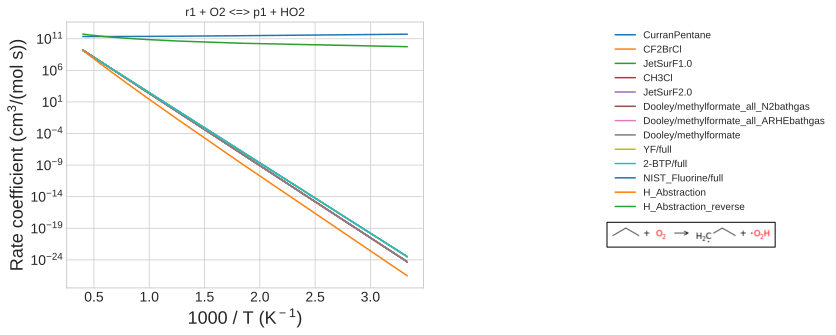

In [10]:
%matplotlib inline
%config InlineBackend.figure_formats = ["svg"]
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

plt.style.use("seaborn-whitegrid")

plt.rcParams["axes.labelsize"] = 18
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.dpi"] = 300

T_min=300 #K
T_max=2500 #K
T_count=10 #step 
temperature = np.linspace(T_min, T_max, T_count)
pressure = 1e7  # Pa  (=100 bar)

fig, ax = plt.subplots()
img = mpimg.imread(img_output_path)

for rxn in [arc_rxn]:
    reaction_order = len(rxn.reactants)
    units = ''
    # get_rate_coefficient returns the k in m^3,mol,s units. Units should be converted into cm^3,mol,s.
    conversion_factor = {1: 1, 2: 1e6, 3: 1e12}
    if reaction_order == 1:
        units = r' (s$^-1$)'
    elif reaction_order == 2:
        units = r' (cm$^3$/(mol s))'
    elif reaction_order == 3:
        units = r' (cm$^6$/(mol$^2$ s))'
    rmg_rxns = list()
    for rmg_rxn in rxn.rmg_reactions:
        rmg_rxn_dict = dict()
        rmg_rxn_dict['rmg_rxn'] = rmg_rxn
        rmg_rxn_dict['T_min'] = rmg_rxn.kinetics.Tmin if rmg_rxn.kinetics.Tmin is not None else T_min
        rmg_rxn_dict['T_max'] = rmg_rxn.kinetics.Tmax if rmg_rxn.kinetics.Tmax is not None else T_max
        k = list()
        temp = np.linspace(rmg_rxn_dict['T_min'], rmg_rxn_dict['T_max'], T_count)
        for T in temp:
            #cm^3,mol,s units
            k.append(rmg_rxn.get_rate_coefficient(T, pressure) * conversion_factor[reaction_order])
        rmg_rxn_dict['k'] = k
        rmg_rxn_dict['T'] = temp
        rmg_rxn_dict['label'] = rmg_rxn.comment
        rmg_rxns.append(rmg_rxn_dict)
    for rmg_rxn in rmg_rxns:
        inverse_temp = [1000 / t for t in rmg_rxn['T']]
        try:
            label = rmg_rxn['rmg_rxn'].library
        except:
            label = rmg_rxn['rmg_rxn'].family
        ax.plot(inverse_temp, rmg_rxn['k'], label= label)
    
    #plot the family rxn REVERSE
    k_r = list()
    temp = np.linspace(rmg_rxn_dict['T_min'], rmg_rxn_dict['T_max'], T_count)
    inverse_temp = [1000 / t for t in rmg_rxn['T']]
    for T in temp:
        #cm^3,mol,s units
        k_r.append(reverse_kinetics.get_rate_coefficient(T, pressure) * conversion_factor[reaction_order])
    ax.plot(inverse_temp, k_r, label= reverse_rxn_family.family+"_REVERSE")

    # Add the image below the legend
    # Define the position of the image in figure coordinates
    image_position = (1.75, 0.2)  # Adjust as needed
    imagebox = OffsetImage(img, zoom=0.7)
    ab = AnnotationBbox(imagebox, image_position, xycoords='figure fraction', boxcoords="axes fraction")
    ax.add_artist(ab)
    ax.set_title(rxn.label)
    ax.set_xlabel(r'1000 / T (K$^-$$^1$)')
    ax.set_ylabel(f'Rate coefficient{units}')
    ax.set_yscale('log')
    ax.legend(loc='upper right',bbox_to_anchor=(2.15, 1))    
    plt.tight_layout()
    plt.show()